In [2]:
import time
import numpy as np

from astropy.time import Time   # Astropy 4.1rc1 is used

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from orbdet.utils.utils import *
from orbdet.utils.utils_vis import *
from orbdet.utils.utils_aux import *

%matplotlib inline

np.random.seed(100)
np.set_printoptions(precision=2)

x_0, t_sec, x_sat_orbdyn_stm, x_obs_multiple, _ = get_example_scenario(id=0, frame='teme')

# Define measurements
r_1, rr_1 = range_range_rate(x_sat_orbdyn_stm, x_obs_multiple[:,:,0])
r_2, rr_2 = range_range_rate(x_sat_orbdyn_stm, x_obs_multiple[:,:,1])
r_3, rr_3 = range_range_rate(x_sat_orbdyn_stm, x_obs_multiple[:,:,2])
z_rr_1 = np.expand_dims(rr_1, axis=0)       # Range rate measurements
_, z_rr_multiple = range_range_rate(x_sat_orbdyn_stm, x_obs_multiple)
z_x_sat = x_sat_orbdyn_stm                  # Full state measurements


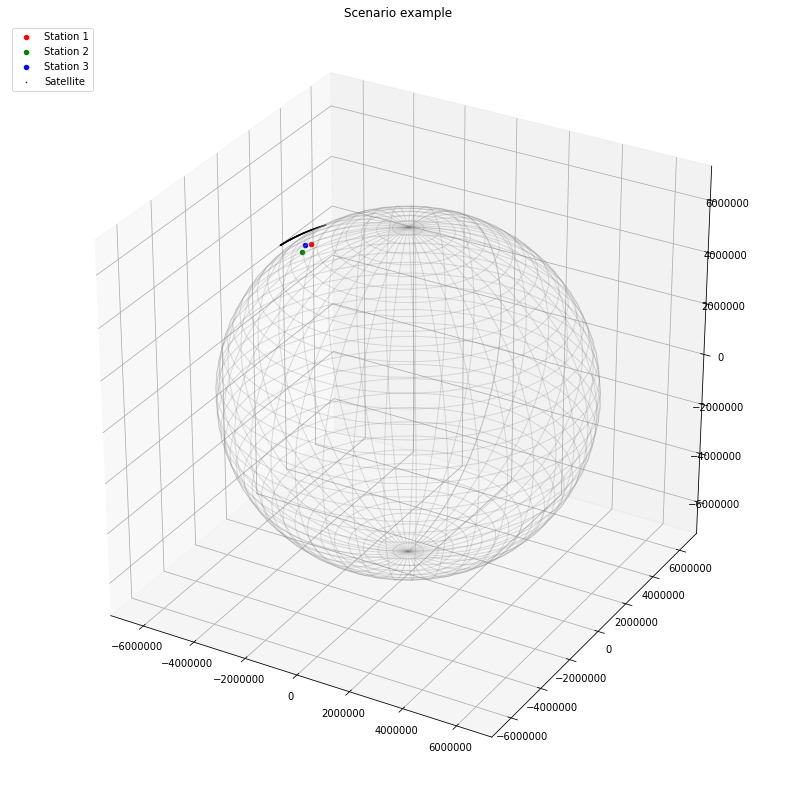

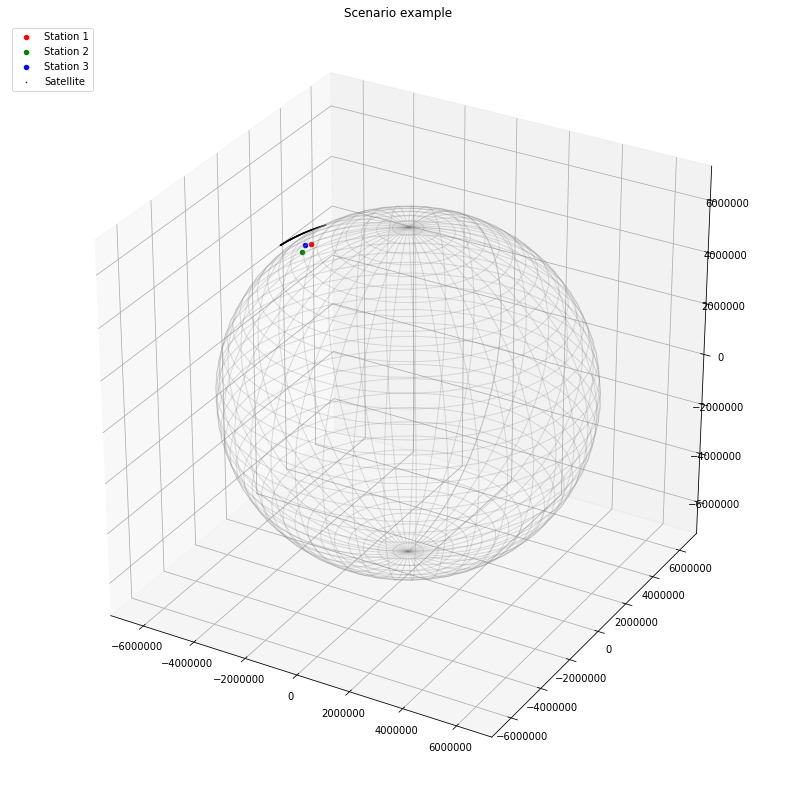

In [3]:
plot_example_3d(x_sat_orbdyn_stm, x_obs_multiple)

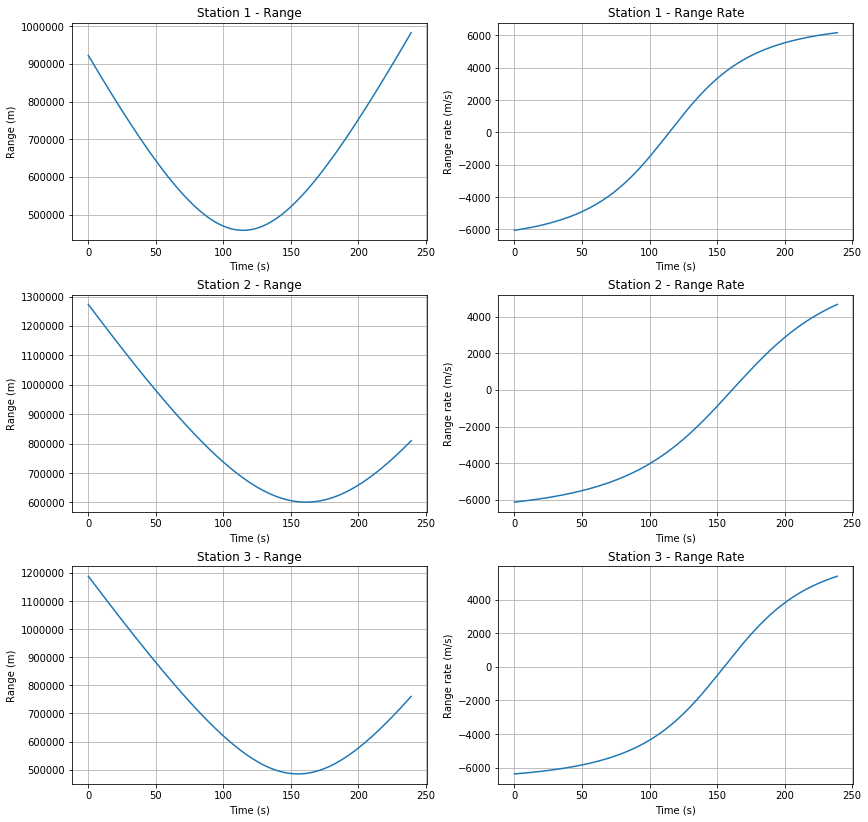

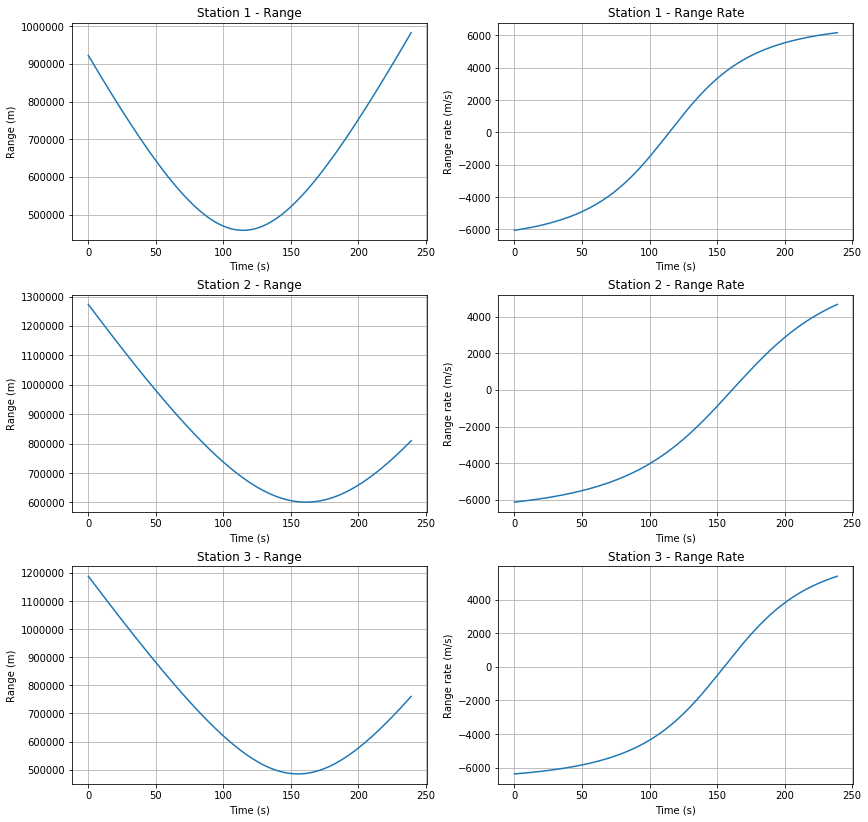

In [4]:
plot_r_rr(x_sat_orbdyn_stm, x_obs_multiple, t_sec)

In [5]:
# Matrices
R_rr_1 = np.eye(1)*1e-6       # Measurement uncertainty range rate (1x1)
R_rr = np.eye(x_obs_multiple.shape[2])*1e-6       # Measurement uncertainty range rate (array)
R_x_sat = np.eye(6)*1e-12     # Measurement uncertainty full state

P_small = np.eye(6)*1e-6                         # Initial state uncertainty - small
P = np.diag([1e4, 1e4, 1e4, 1e2, 1e2, 1e2])      # Initial uncertainty - random guess
P = np.diag([1,1,1,1,1,1])*1e5      # Initial uncertainty - random guess

# Random sampling
n_samples = 100
x_0r = np.random.multivariate_normal(x_0.squeeze(), P, n_samples).T
x_0err = x_0r - x_0

verbose = True

start_time = time.time()
#####   Batch Test 2_1 - Range rate, random samples, multiple measurements     #####
run_batch_2_1 = True
if run_batch_2_1 == True:     

    x_br = np.zeros(x_0r.shape)
    x_berr = np.zeros(x_0r.shape)
    if verbose:
        print(f"Batch 2_1 Output:")

    for i in range(n_samples):

        x_b, output = batch(
            np.copy(np.expand_dims(x_0r[:,i], axis=1)), P, R_rr, z_rr_multiple, t_sec, x_obs_multiple, 
            f_obs=f_obs_range_rate, tolerance=1e-8, max_iterations=100)
        x_br[:,i] = x_b.squeeze()
        x_berr[:,i] = (x_0 - x_b).squeeze()
        x_berr1 = (x_0 - x_b).T

        if verbose:
            print(f"{i} Number of iterations", output['num_it'])
            print(f"err_1: \t{x_0err[:,i]}, Norm pos {np.linalg.norm(x_0err[0:3,i])}, \
                Norm vel {np.linalg.norm(x_0err[3:6,i])}")
            print(f"err_2: \t{x_berr1}, Norm pos {np.linalg.norm(x_berr1[0:3])}, \
                Norm vel {np.linalg.norm(x_berr[3:6])}")

print(f"Elapsed {(time.time()-start_time):.2f} s")


128.93 -261.93], Norm pos 254.13341206808084,                 Norm vel 538.1908852665529
err_2: 	[[-3.68e-06  1.11e-06 -1.42e-06  1.73e-08 -8.53e-09 -1.42e-09]], Norm pos 4.102228103157813e-06,                 Norm vel 4.3727881879844593e-07
36 Number of iterations 7
err_1: 	[ 133.91  -50.44  392.46  526.06 -209.32 1095.8 ], Norm pos 417.737549956948,                 Norm vel 1233.4226277371813
err_2: 	[[-6.95e-07  4.54e-07 -6.12e-06  5.94e-09  5.16e-09  1.70e-08]], Norm pos 6.172508345184173e-06,                 Norm vel 4.376811210334585e-07
37 Number of iterations 7
err_1: 	[ 123.78  103.48  -98.46 -450.52 -197.6   -34.78], Norm pos 189.01076843049452,                 Norm vel 493.174186418268
err_2: 	[[-3.94e-06 -3.50e-07  2.74e-06  2.23e-08 -9.90e-09 -1.88e-08]], Norm pos 4.810406291603679e-06,                 Norm vel 4.3876416456939467e-07
38 Number of iterations 8
err_1: 	[ 301.35 -310.97 -346.13  -76.32 -188.19 -310.79], Norm pos 554.3635270872106,                 Norm vel 371

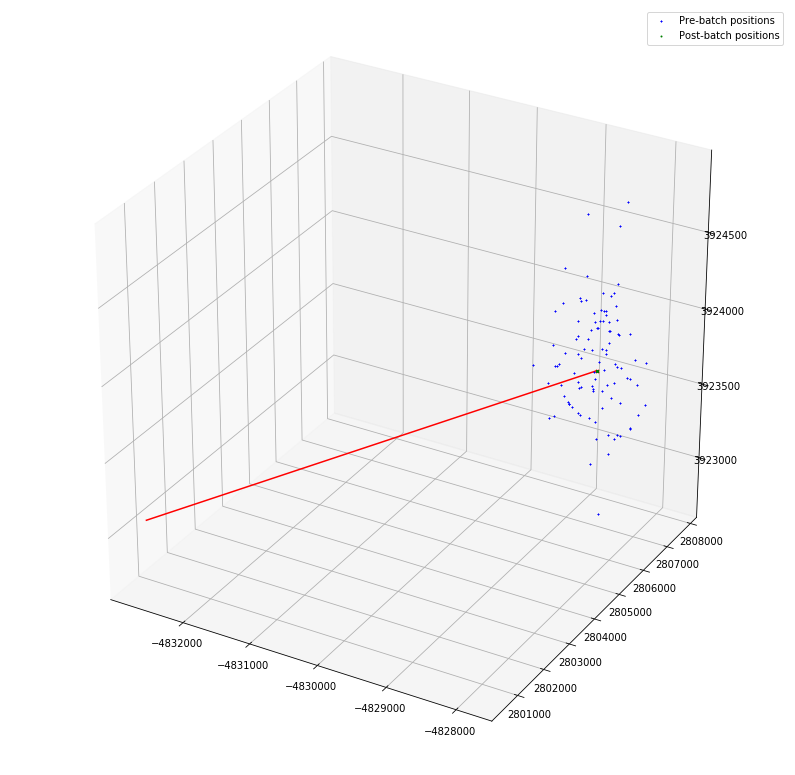

In [8]:
fig = plt.figure(figsize=(14,14))
ax1 = fig.add_subplot(111, projection='3d')

# Groundtruth
ax1.scatter(x_0[0], x_0[1], x_0[2], s=10, marker='x', c = 'r')

x_berr_norm = np.linalg.norm(x_berr, axis=0)
norm_mask = x_berr_norm < 1000

s1 = ax1.scatter(x_0r[0, i], x_0r[1, i], x_0r[2, i], c='b', s=1, marker='x')
s2 = ax1.scatter(x_br[0, i], x_br[1, i], x_br[2, i], c='g', s=1)
traj = ax1.plot(x_sat_orbdyn_stm[0,:2], x_sat_orbdyn_stm[1,:2], x_sat_orbdyn_stm[2,:2], c='r')

# Batch results
for i in range(n_samples):
    if x_berr_norm[i] < 1000:
        ax1.scatter(x_0r[0, i], x_0r[1, i], x_0r[2, i], c='b', s=1, marker='x')
        ax1.scatter(x_br[0, i], x_br[1, i], x_br[2, i], c='g', s=1)

ax1.legend((traj, s1, s2), ('Groundtruth trajectory', 'Pre-batch positions', 'Post-batch positions'))
